# 기본적으로 F에 noise를 준다.(크레인의 기울기에 의한 중력으로 가정)
# 가장 안정한 순간에 r=1, y=0 으로 하고, eligibility를 초기화한다.




# 데이터 분류
data_fail         : 실패시 모든 trial에 대한 success_times, fail_reason, 마지막 dec info(4개) 

          분류할 때 key가 됨

data_dt           : success step / x loc / x vel / theta loc / theta vel / I index / Wi / y / elig

In [1]:
import sys
sys.path

['',
 'C:\\Program Files\\Python36\\python36.zip',
 'C:\\Program Files\\Python36\\DLLs',
 'C:\\Program Files\\Python36\\lib',
 'C:\\Program Files\\Python36',
 'C:\\Program Files\\Python36\\lib\\site-packages',
 'C:\\Program Files\\Python36\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\동현\\.ipython']

In [2]:
sys.path.insert(0, 'C:\\ProgramData\\Miniconda3\\lib\\site-packages')

In [1]:
# 패키지 
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.ticker as ticker

save_path = 'data/2d_inverted_pendulum_std1_only_ASE_'

In [2]:
# 함수 정의
# 가속도 계산
def acc_theta(force, theta_loc, theta_vel, x_vel):
    a = g*np.sin(theta_loc)  # radian인지, 각도인지 check
    b = np.cos(theta_loc) * (- force - m*l*theta_vel*theta_vel*np.sin(theta_loc) + uc*sgn(x_vel))/(mc+m)
    c = -up * theta_vel / (m*l)
    d = l*(4/3 - m*(np.cos(theta_loc))**2 / (mc + m))
    
    return (a + b + c)/d

def acc_x(force, theta_acc, theta_vel, theta_loc, x_vel):
    b = m*l*(theta_vel**2*np.sin(theta_loc) - theta_acc*np.cos(theta_loc))
    c = -uc*sgn(x_vel)
    
    return (force + b + c)/(mc + m)

# 실패했을 때 처벌
def failure_test(x_loc, theta_loc):
    
    if (range_failure_x[0] <= x_loc <= range_failure_x[1]) and (range_failure_theta[0] <= theta_loc <= range_failure_theta[1]):
        return 0
    
    else :
        return -1
    
# 실패 이유
# 실패 했을 때만 사용함
# x loc (0,1), theta loc (2,3)으로 표기 한다.
def fail_reason(x_loc, theta_loc):
    
    reason1 = -10
    reason2 = -10
    
    # x loc
    if x_loc < range_failure_x[0]:
        reason1 = 0
    
    elif x_loc > range_failure_x[1]:
        reason1 = 1
    
    # theta loc
    if theta_loc < range_failure_theta[0]:
        reason2 = 2
    
    elif theta_loc > range_failure_theta[1]:
        reason2 = 3
    
    # 두 이유 중 하나만 있을 때
    if ((reason1 + reason2) < 0):
        
        if reason1 > reason2 :
            return reason1
        else :
            return reason2
    
    # 두 이유 모두 작용할 때
    else :
        return reason1*10 + reason2
    
# 입력에 대한 Index, state 출력
def decoder(x_loc, x_vel, theta_loc, theta_vel):
    state = np.zeros((162))
  
    for ii, xx in enumerate(range_x_loc):
        index_x_loc = ii
        
        if x_loc < xx:
            break
        else : 
            index_x_loc += 1
            
    for ii, xx in enumerate(range_x_vel):
        index_x_vel = ii
        
        if x_vel < xx:
            break
        else : 
            index_x_vel += 1     
            
    for ii, xx in enumerate(range_theta_loc):
        index_theta_loc = ii
        
        if theta_loc < xx:
            break
            
        else : 
            index_theta_loc += 1
            
    for ii, xx in enumerate(range_theta_vel):
        index_theta_vel = ii
        
        if theta_vel < xx:
            break
            
        else : 
            index_theta_vel += 1

    # 162/3 = 54, 162/(3*3) = 18, 162/(3*3*6) = 3, 162/(3*3*6*3) = 1
    Index = 54*index_x_loc + 18*index_x_vel + 3*index_theta_loc + index_theta_vel
    
    # 실패 안 했을 때만 1 추가하기
    if failure_test(x_loc, theta_loc) == 0:
        state[Index] = 1
    
    return Index, state
    
def sgn(x):
    
    if x >= 0 :
        return 1
    else :
        return -1
    

In [3]:
# 상수 정의
dt = 0.02
sigma = 0.01
alpha = 1000
delta = 0.9

g = 9.8
mc = 1
m = 0.1
l = 0.5
uc = 0.0005
up = 0.000002
max_count = 80000


# decoder index 계산 시
num_x_loc = 162/3
num_x_vel = 162/3/3
num_theta_loc = 162/3/3/6
num_theta_vel = 162/3/3/6/3

# 실패 범위
range_failure_x = [-2.4, 2.4]
range_failure_theta = [-12*np.pi/180, 12*np.pi/180]

# decoder 범위
range_x_loc = [-0.8, 0.8]
range_x_vel = [-0.5, 0.5]
range_theta_loc = np.array([-6, -1, 0, 1, 6], dtype=np.float64)
range_theta_vel = np.array([-50, 50], dtype=np.float64)

# radian으로 변경
range_theta_loc *= np.pi/180
range_theta_vel *= np.pi/180


In [54]:
# state array 만들기
# 각 state별 index 사전으로 보면 됨
# 각 state별로 나온 횟수 count도 함

dic_state_info = []

# index 정의
all_x_loc = [-1, 0, 1]
all_x_vel = [-1, 0, 1]
all_theta_loc = [-3, -2, -1, 1, 2, 3]
all_theta_vel = [-1, 0, 1]

# index 넣기
Index = 0
for i in all_x_loc:
    for ii in all_x_vel:
        for iii in all_theta_loc:
            for iiii in all_theta_vel:
                # 마지막(6열)은 count를 위한 공간
                dic_state_info.append([i, ii, iii, iiii, Index, 0])
                Index += 1

In [56]:
# data 배열
data_W = []
data_fail = []         # success_times, fail_reason, 마지막 dec info(4개) 
data_dt = []       # 모든 dt 간격으로의 정보

# 추가 데이터 분석
data_elig_dt = []

# 초기 weight 생성
W = np.zeros((162))

# 학습 Loop

In [57]:
# total trial
total_trial_num = 5

for failure_count in range(total_trial_num):
    
    # 실패 후 초기화함.
    # 변수 초기화 (weight는 초기화하지 않음.)
    x_loc = 0
    x_vel = 0
    theta_loc = 0
    theta_vel = 0
    elig = np.zeros((162))
    
    # decoder index
    Index, state = decoder(x_loc, x_vel, theta_loc, theta_vel)
    Indexes = dic_state_info[Index][:4]

    
    # dt 간격으로 저장할 list 초기화
    d_dt = []
    success_step = 0
    d_elig_dt = []
    
    # 전 weight와 후 weight를 비교하기 위해.
    # 데이터 저장 용.
    W0 = W*1
    
    d_W = []
    d_W.append(W0*1)
    
    # trial마다 같은 noise 주기 위해
    np.random.seed(9001)
    
    # loop 시작
    while success_step < max_count:
        
        # ASE
        noise = np.random.normal(0, sigma)
        X = W[Index] + noise   # noise는 gaussian dist.
        y = sgn(X)
        
        # t초의 카트 미는 힘 계산
        # 안전 범위 안에 있으면 y=0
        force = y * 10        
        
        # t+dt eligibility
        # elig = delta*elig + (1-delta)*y*state
        elig = delta*elig + (1-delta)*y*state

        
        # t초의 data 저장, 매 dt마다.
        # 위치 계산되기 전에 저장한다.
        # r_hat은 나중에 계산 후 저장.
        d_dt.append([success_step, 
                     Indexes[0], Indexes[1], Indexes[2], Indexes[3], Index,
                     W[Index], y, elig[Index]])
        
        dic_state_info[Index][-1] += 1
        
        ####################### 시뮬레이션 t+dt update
        # 가속도 계산
        theta_acc = acc_theta(force, theta_loc, theta_vel, x_vel)
        x_acc = acc_x(force, theta_acc, theta_vel, theta_loc, x_vel)

        # 속도, 위치 계산
        # Euler's methods
        theta_vel += theta_acc*dt
        x_vel += x_acc*dt

        # 위치 update
        theta_loc += theta_vel*dt
        x_loc += x_vel*dt     
        
        #######################
        
        # decoder index
        # update된 state
        Index, state = decoder(x_loc, x_vel, theta_loc, theta_vel)
        Indexes = dic_state_info[Index][:4]
        
        # reinforce 계산
        r = failure_test(x_loc, theta_loc)
        
        
        # 실패했을 때
        if r == -1:
            
            # weight update
            W += alpha * r * elig
            
            # end of while loop
            # fail count 출력
            print('failure {0}'.format(failure_count+1))
            
            # 저장
            d_elig_dt.append(elig*1)
            # r 저장
            d_dt[-1].append(r)
            
            # while loop를 나간다.
            break
            
        # 실패하지 않았을 때
        else:
            
            # step count + 1
            success_step += 1
            
            # max_count 넘겼을 때 성공 출력하기
            if not(success_step < max_count) :
                print('success {0}'.format(failure_count+1))
            
            # 저장
            d_elig_dt.append(elig*1)
            # r 저장
            d_dt[-1].append(r)
                
    
    # save data (data_dec_dt는 나중에 따로 계산)
    data_fail.append(np.array([failure_count, success_step, 
                               fail_reason(x_loc, theta_loc), y, Index,
                               Indexes[0], Indexes[1], Indexes[2], Indexes[3]]))
    data_dt.append(d_dt)
    d_W.append(W*1)
    data_W.append(d_W)      # array는 복사하려면 *1을 해줘야 하더라.
    
    data_elig_dt.append(d_elig_dt)
    
    # cpu 부담 경감
    time.sleep(0.001)
    
    

failure 1
failure 2
failure 3
failure 4
failure 5
failure 6
failure 7
failure 8
failure 9
failure 10
failure 11
failure 12
failure 13
failure 14
failure 15
failure 16
failure 17
failure 18
failure 19
failure 20
failure 21
failure 22
failure 23
failure 24
failure 25
failure 26
failure 27
failure 28
failure 29
failure 30
failure 31
failure 32
failure 33
failure 34
failure 35
failure 36
failure 37
failure 38
failure 39
failure 40
failure 41
failure 42
failure 43
failure 44
failure 45
failure 46
failure 47
failure 48
failure 49
failure 50
failure 51
failure 52
failure 53
failure 54
failure 55
failure 56
failure 57
failure 58
failure 59
failure 60
failure 61
failure 62
failure 63
failure 64
failure 65
failure 66
failure 67
failure 68
failure 69
failure 70
failure 71
failure 72
failure 73
failure 74
failure 75
failure 76
failure 77
failure 78
failure 79
failure 80
failure 81
failure 82
failure 83
failure 84
failure 85
failure 86
failure 87
failure 88
failure 89
failure 90
failure 91
failure 

In [58]:
# array로 만들어야 argsort를 쓸 수 있음
data_fail = np.array(data_fail)

# index 별 의미
# 0 : trial count
# 1 : success step
# 2 : fail reason
# 3 : 실패 했을 때 y
# 4 : i index(0 ~ 161)
# 5 ~ 8 : decoder state index(4 variable)

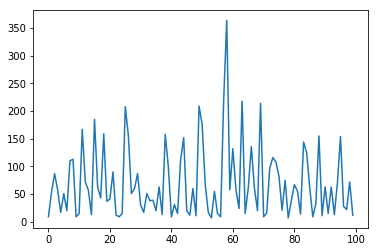

In [59]:
plt.plot(data_fail[:,1])
plt.show()

C:\Users\hyeon\AppData\Local\Continuum\miniconda3\lib\site-packages\numpy\lib\function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\hyeon\AppData\Local\Continuum\miniconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


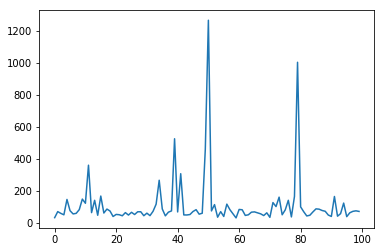

In [9]:
# success count plot
# 10개씩 평균

ave_success_count = []
for i in range(len(data_fail)):
    
    ave_success_count.append(np.average(data_fail[i*10 : (i+1)*10, 1]))

plt.plot(ave_success_count)
# plt.ylim(ymin=0)
plt.show()

# Data 분석에 필요한 계산


In [88]:
# data 분류 후 저장
# 계산 루프랑 분석 루프랑 분리함

data_list_i_idx = []  # 중복 없이 trial마다 I index를 저장
data_learning_W = []

# data_dt 의 데이터
# success step / x_loc / x_vel / theta_loc / theta_vel / I index / 
# Wi / y / elig / Vi / xi_elig / r_hat

for fc in range(len(data_dt)):
    
    # 분석할 데이터
    data_anal = np.array(data_dt[fc])
    
    # 중복 없이 먼저 나왔던 state 순서대로 들어간다.
    list_i_idx = []
    for i in data_anal[:,5]:
        i = int(i)

        try:
            # i가 list_i_idx에 없으면 오류가 나와서 except로 이동함
            list_i_idx.index(i)

        except:
            # 없으면 추가해준다.
            list_i_idx.append(int(i))
            
    data_list_i_idx.append(list_i_idx)

    
    ###################################
    # learning data 만들기    
    # 위에 중복 없앤 나왔던 state만 모은 list 활용
    d_learning_W = []
    
    for i in list_i_idx:
        d_l_W = []

        # state index 넣기
        d_l_W.extend(dic_state_info[i][0:4])
        d_l_W.append(i)
    
        # 학습 전 데이터 넣기
        d_l_W.append(data_W[fc][0][i])
        
        # 학습 후 데이터 넣기
        d_l_W.append(data_W[fc][1][i])

        d_learning_W.append(d_l_W)
        
    data_learning_W.append(d_learning_W)
    


In [22]:
# trial 별로 data_learning_W 메모장으로 옮기기
# 액셀로 옮기기 위함

# 저장할 데이터
save_data = data_learning_W
save_name = 'learning_W'

# 저장할 메모장 열기
f = open(save_path + save_name + ".txt", 'w')

# 액셀에서 수식으로 적으려고 비움.
data_list_learning = ['', '', '', '', '', '']
data_list_learning1 = ['x_loc', 'x_vel', 'theta_loc', 'theta_vel', 'I index', 'V']

# I index 까지의 길이
len_Iindex = data_list_learning1.index('I index') + 1

for i,x in enumerate(save_data):
    
    # 몇 번째 시도인지 쓰기
    f.write('f{0}'.format(i+1))
    
    # 한 줄 띄우기
    f.write('\n')
    
    # 전체 데이터 길이
    len_W = len(x[0])
  
    # data list 넣기
    # 마지막 것 제외
    for xx in data_list_learning[:len_Iindex]:
        f.write(str(xx) + '\t')
    
    # W의 크기만큼
    for ii in range(len_W - len_Iindex):
        f.write(str(ii) + '\t')
        
    f.write('\n')
    
    for xx in x:
        for xxx in xx:
            # 정수는 그냥 쓰고, 실수형은 소수점 3자리까지만 표시
            # 0이면 그냥 0 씀
            if (xxx != 0) and (type(xxx) == np.float64):
                f.write('{0:.3f}\t'.format(xxx))
            else :
                f.write(str(xxx) + '\t')
        
        # 한 state 다 썼으면 줄 띄우기
        f.write('\n')
            
    # i 번째 시도 다 썼으면 한 줄 띄우기
    f.write('\n')

# 다 썼으면 메모장 닫기
f.close()

# 실패 state별 분석

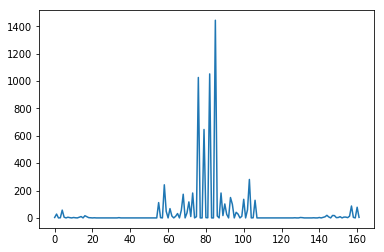

In [81]:
# state 별 점유율
state_idx_count = np.array(dic_state_info)[:,-1]
plt.plot(state_idx_count)
plt.show()

In [85]:
# 한 번이라도 나온 state 출력
np.nonzero(state_idx_count)

(array([  0,   1,   3,   4,   5,   7,   8,  10,  11,  13,  14,  16,  17,
         18,  19,  21,  34,  55,  56,  58,  59,  61,  62,  64,  65,  67,
         68,  70,  71,  72,  73,  75,  76,  79,  80,  81,  82,  85,  86,
         88,  89,  90,  91,  93,  94,  96,  97,  99, 100, 102, 103, 105,
        106, 127, 130, 131, 137, 140, 142, 143, 144, 145, 147, 148, 149,
        150, 151, 153, 154, 155, 156, 157, 158, 160, 161], dtype=int64),)

In [86]:
# 모든 실패 state 출력
print(data_fail[:,4])

[ 90  71  89  71  90  90  90  90 144  89  71 161  90  88  71 143  90  55
  18  71  73  91  90  89  71 161 160  90  71 144 106  89  71  71  71  73
  90  71 143  17  89  72  71  90 144  71  71  73  90   1  17  71  73  71
  90  71  72 144  17  90  71  73  90  71  71  73  90  73  73  90  89  90
 144 157 160 144  90  71  71  71  71  90  90  17  71  73  89  90 143  71
  71  71  90  71  90   1  71  71  71  90]


In [49]:
# 원하는 state index 찾기
np.where(data_fail[:,4] == 71)

(array([ 1,  3, 10, 14, 19, 24, 28, 32, 33, 34, 37, 42, 45, 46, 51, 53, 55,
        60, 63, 64, 77, 78, 79, 80, 84, 89, 90, 91, 93, 96, 97, 98],
       dtype=int64),)

In [90]:
idx = 4

# dt data
data_dt[idx]

[[0, 0, 0, 1, 0, 82, 36.17377931222148, 1, 0.09999999999999998, 0],
 [1, 0, 0, -1, 0, 79, -18.305040986046365, -1, -0.09999999999999998, 0],
 [2, 0, 0, -1, 0, 79, -18.305040986046365, -1, -0.18999999999999995, 0],
 [3, 0, 0, -1, 0, 79, -18.305040986046365, -1, -0.2709999999999999, 0],
 [4, 0, 0, 1, 0, 82, 36.17377931222148, 1, 0.16560999999999998, 0],
 [5, 0, 0, 1, 0, 82, 36.17377931222148, 1, 0.24904899999999996, 0],
 [6, 0, 0, 2, 0, 85, 165.4298838390554, 1, 0.09999999999999998, 0],
 [7, 0, 0, 1, 0, 82, 36.17377931222148, 1, 0.30172968999999994, 0],
 [8, 0, 0, 1, 0, 82, 36.17377931222148, 1, 0.3715567209999999, 0],
 [9, 0, 1, -1, 0, 97, 0.02697216055906082, 1, 0.09999999999999998, 0],
 [10, 0, 1, -2, -1, 93, -132.60509999999996, -1, -0.09999999999999998, 0],
 [11, 0, 1, -2, -1, 93, -132.60509999999996, -1, -0.18999999999999995, 0],
 [12, 0, 0, -2, 0, 76, 131.97633667490263, 1, 0.09999999999999998, 0],
 [13, 0, 1, -2, -1, 93, -132.60509999999996, -1, -0.2538999999999999, 0],
 [14, 0, 

In [91]:
# W data
data_learning_W[idx]

[[0, 0, 1, 0, 82, 36.17377931222148, -107.77490722883513],
 [0, 0, -1, 0, 79, -18.305040986046365, 43.691066566897945],
 [0, 0, 2, 0, 85, 165.4298838390554, 134.0488242300554],
 [0, 1, -1, 0, 97, 0.02697216055906082, -43.01974883944095],
 [0, 1, -2, -1, 93, -132.60509999999996, 33.97868999999997],
 [0, 0, -2, 0, 76, 131.97633667490263, 0.027336674902642244],
 [0, 1, -3, -1, 90, 108.99999999999997, -161.99999999999991]]

In [87]:
# 실패 index 정리. count까지
idx = data_fail[:,4].argsort()
# print(data_fail[idx,4])

fail_idx_count = []
for i in set(data_fail[idx,4]):
    fic = []
    count = len(np.where(data_fail[:,4] == i)[0])
    
    fic.extend(dic_state_info[i][:5])
    fic.append(count)
    
    fail_idx_count.append(fic)
    
# count 크기 순서대로 정렬
idx_sort = np.array(fail_idx_count)[:,-1].argsort()
fail_idx_count = np.flip(np.array(fail_idx_count)[idx_sort], 0)

In [76]:
# 실패가 많이 발생한 순서대로 나열
fail_idx_count

array([[  0,  -1,   3,   1,  71,  32],
       [  0,   1,  -3,  -1,  90,  25],
       [  0,   0,  -3,   0,  73,   9],
       [  0,   0,   3,   1,  89,   7],
       [  1,   1,  -3,  -1, 144,   6],
       [ -1,  -1,   3,   1,  17,   4],
       [  1,   0,   3,   1, 143,   3],
       [ -1,  -1,  -3,   0,   1,   2],
       [  1,   1,   3,   1, 161,   2],
       [  0,   0,  -3,  -1,  72,   2],
       [  1,   1,   3,   0, 160,   2],
       [  0,   1,   3,   0, 106,   1],
       [  0,   1,  -3,   0,  91,   1],
       [ -1,   0,  -3,  -1,  18,   1],
       [  0,  -1,  -3,   0,  55,   1],
       [  0,   0,   3,   0,  88,   1],
       [  1,   1,   2,   0, 157,   1]])

# Graph plot

In [10]:
# color 정의
data_color = ['b', 'g', 'y', 'k', 'm', 'r', 'c']

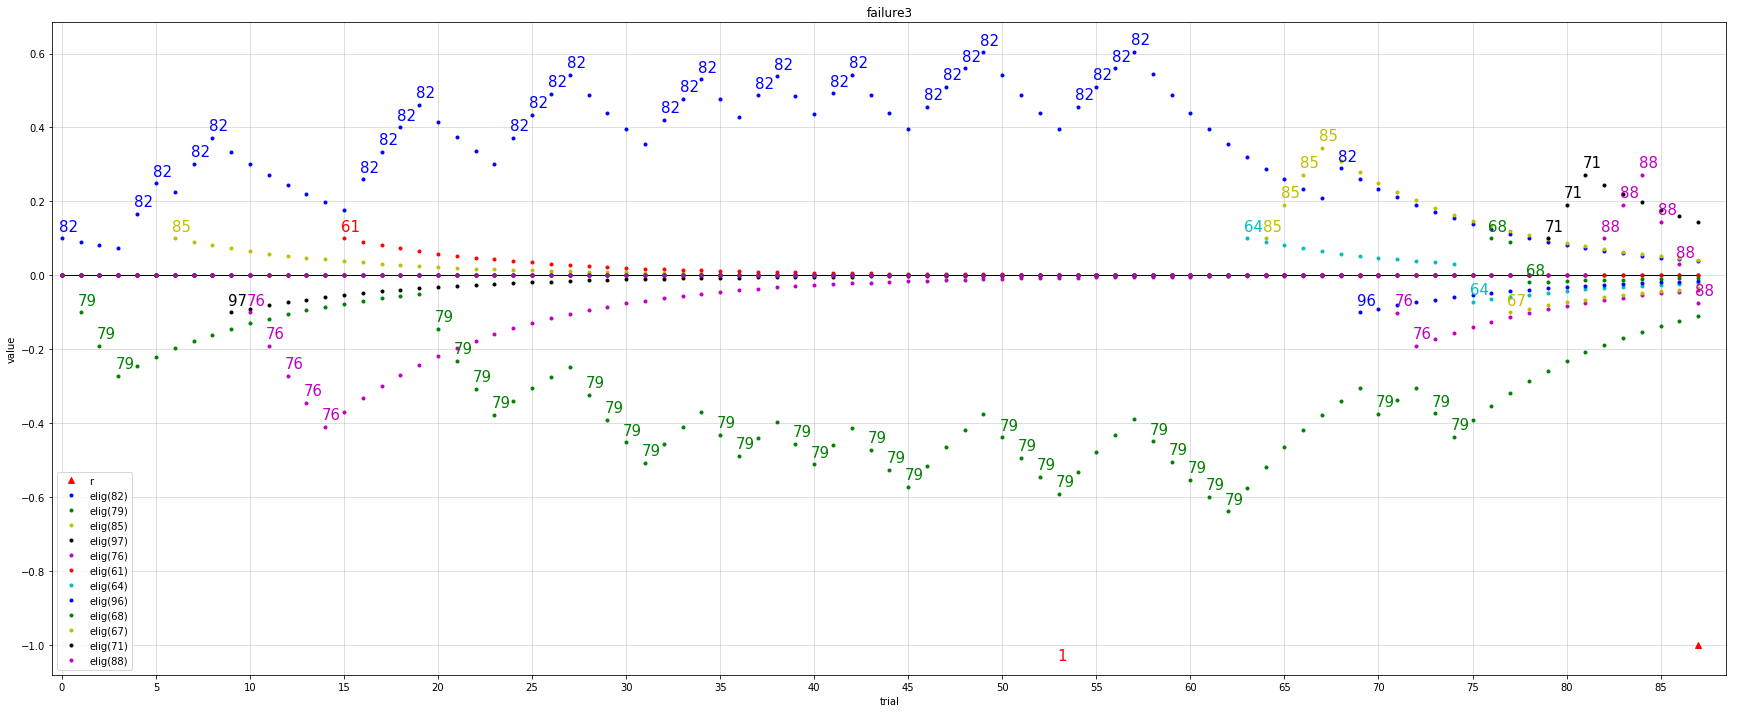

In [13]:
# r / elig

# trial 선택
idx = 2
fig_size = (30, 12)
text_state_size = 15
text_legend_size = 10

# data 범위 설정
start_idx = 0
end_idx = len(data_dt[idx])

# 끝자락 데이터 더 잘 보이도록
start_idx -= 0.5
end_idx += 0.5

# elig data
anal_data = np.array(data_elig_dt[idx])
name_data = 'elig'

fig, ax = plt.subplots(figsize = fig_size)

# title
plt.title('failure{0}'.format(idx+1))

# 기준 선
plt.plot([0, len(data_dt[idx])-1], [0,0], '-k', linewidth=1)

###############################################
# r
label_bool = True      # label을 하나만 넣기 위한 변수
reinf_count = 0         # trial 안에서 몇 번째 강화인지

# r data
x = data_dt[idx][-1][-1]

# data 점 찍기
# 처음 들어가는 데이터만 label 넣음. 안 그러면 label 여러 개가 들어가짐.
if label_bool:
    plt.plot(len(data_dt[idx]) -1, x, '^r', label='r')
    plt.legend(prop={'size': text_legend_size})
    label_bool = False

else :
    plt.plot(i, x, '^r')

# 숫자 표기
reinf_count += 1
ax.annotate(str(reinf_count), xy=(i, x), xytext=(i - 0.1, x - 0.04), 
            color='r', size=text_state_size)

###############################################
# elig
# graph plot
for i,x in enumerate(data_list_i_idx[idx]):
    plt.plot(anal_data[:,x], '.' + data_color[i%len(data_color)], 
             label='{0}({1})'.format(name_data, x), 
             linewidth = 0.1)
    plt.legend(prop={'size': text_legend_size})

# I index를 넣어서 각 시간에 존재하는 state의 x elig만 찾는다.
# index 로 넣어줄 것이므로 int로 만듦
eachTime_state = np.array(data_dt[idx], dtype=np.int32)[:,5]

for i,x in enumerate(eachTime_state):
    
    # 같은 state는 색깔 고정으로 나오도록
    unique_idx = data_list_i_idx[idx].index(x)
    
    # state 숫자 표기
    data_elig = anal_data[i,x]
    ax.annotate(str(x), xy=(i, data_elig), 
                xytext=(i - 0.16, data_elig + 0.02), 
                color=data_color[unique_idx%len(data_color)], size=text_state_size)
    
# grid 간격 조정
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

# Or if you want different settings for the grids:
ax.grid(which='major', alpha=0.5)

plt.xlabel('trial')
plt.ylabel('value')
plt.xlim(xmin=start_idx, xmax=end_idx)
fig.savefig('hhh.png')
plt.show()

In [79]:
dic_state_info[76]

[0, 0, -2, 0, 76, 1026]

In [ ]:
# PV plot

# 그래프 크기
fig_size = (5,5)

# 원하는 step 까지만 그래프 보기. end = -1 이면 전체 의미.
end = -1

# output x
s11 = np.array(list_loc)[:end,0]         # x loc
s12 = ref_x_loc * np.ones((len(t)))      # reference

# output theta
s21 = np.array(list_loc)[:end,1]         # theta loc
s22 = ref_theta_loc * np.ones((len(t)))      # reference


# Create two subplots
fig, (ax1, ax2) = plt.subplots(2, figsize=fig_size)

"""
# 제목 붙이기
str_title = 
fig.suptitle(str_title, fontsize=15)
"""

# 첫 번째 그래프 plot
ax1.plot(t, s11, 'b-', label='PV x')
ax1.plot(t, s12, 'y-', label='reference')
ax1.legend(prop={'size': 10})
ax1.set(ylabel='x loc (m)')
# ax1.grid()

# 두 번째 그래프

ax2.plot(t, s21, 'b-', label='PV theta')
ax2.plot(t, s22, 'y-', label='reference')
ax2.legend(prop={'size': 10})
ax2.set(ylabel='theta loc (radian)')
# ax2.grid()                                  # grid

plt.show()


# data 저장

In [9]:
# dt 간격 데이터 메모장으로 옮기기
# simulation 구현 위함

# 저장할 메모장 열기
f = open(save_path + "dt.txt", 'w')

data_list_dt = ['step', 'x_loc', 'x_vel', 'theta_loc', 'theta_vel', 'I index',
                'Wi', 'y', 'ei', 'r']

for i,x in enumerate(data_dt):
    
    # 몇 번째 시도인지 쓰기
    f.write('failure{0} \n'.format(i+1))
    
    # data list 넣기
    for xx in data_list_dt:
        f.write(xx + '\t')
    f.write('\n')
        
    # dt 데이터 넣기
    # i 번째 시도
    for xx in x:
        # success step 별로 data 원소 넣기
        for xxx in xx:
            # 정수는 그냥 쓰고, 실수형은 소수점 3자리까지만 표시
            # 0이면 그냥 0 씀
            if (xxx != 0) and (type(xxx) == np.float64):
                f.write('{0:.3f}\t'.format(xxx))
            else :
                f.write(str(xxx) + '\t')
        
        # 한 success step 다 썼으면 줄 띄우기
        f.write('\n')
            
    # i 번째 시도 다 썼으면 두 줄 띄우기
    f.write('\n\n')

# 다 썼으면 메모장 닫기
f.close()

In [29]:
# data_fail 저장하기

# 저장할 메모장 열기
f = open(save_path + "fail.txt", 'w')

data_list_fail = ['trial', 'step', 'f_reason', 'last y', 'I index',
                      'x_loc', 'x_vel', 'theta_loc', 'theta_vel']

# data list 넣기
for xx in data_list_fail:
    f.write(xx + '\t')
f.write('\n')

# fail 데이터 넣기
for i,x in enumerate(data_fail):
    for xx in x:
        f.write(str(xx) + '\t')
        
    # 줄 띄우기
    f.write('\n')

# 다 썼으면 메모장 닫기
f.close()

In [26]:
# npy로 저장
np.save(save_path + 'fail', data_fail)